# This is the final ipynb 

<h2> This notebook contains two functions</h2> <br>
    1. final_fun_1 which take test data and predict output<br>
    2. final_fun_2 which take data with output and print metrics

# first function
## final_fun_1

>_ below are some helper functions

In [1]:
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
from functools import reduce
import pickle
import pandas as pd
from keras.models import model_from_json
import numpy as np

Using TensorFlow backend.


In [2]:
def magic(member_data,transaction,user_logs,user_logs_jan,user_logs_feb):
    """
    This function preprocess the test data
    age_mean contains mean of age from train data
    via contains the mode of payment method of train data
    
    Input 5 dataFrames
    order = member_data transaction user_log_march user_logs_jan , user_log_feb
    
    """
    
    def adjust_datatype(df):
        """
        This function adjust the datatypes of columns based upon their range

        Input take DataFrame

        example:
        if a column's maximum and minimum values are in range of (-128 to 127) then datatype
        to store that column is changed to int8

        Reference:
        https://www.kaggle.com/jeru666/did-you-think-of-these-features

        """


        int_cols = list(df.select_dtypes(include=['int']).columns)
        for col in int_cols:
            if ((np.max(df[col]) <= 127) and (np.min(df[col] >= -128))):
                df[col] = df[col].astype(np.int8)
            elif ((np.max(df[col]) <= 32767) and (np.min(df[col] >= -32768))):
                df[col] = df[col].astype(np.int16)
            elif ((np.max(df[col]) <= 2147483647) and (np.min(df[col] >= -2147483648))):
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)          
        float_cols = list(df.select_dtypes(include=['float']).columns)
        for col in float_cols:
            df[col] = df[col].astype(np.float32)
        
        
        
        

    
    age=29.487728
    via=4
    adjust_datatype(user_logs)
    adjust_datatype(user_logs_jan)
    adjust_datatype(user_logs_feb)
    member_data.drop('gender',axis=1,inplace=True)
    
    member_data.drop_duplicates(inplace=True)
    transaction.drop_duplicates(inplace=True)
    user_logs.drop_duplicates(inplace=True)
    user_logs_jan.drop_duplicates(inplace=True)
    user_logs_feb.drop_duplicates(inplace=True)
    
    member_data['bd']=member_data['bd'].apply(lambda x :np.nan if (x <=0 or x >100) else x)
    member_data['bd'].fillna(age,inplace=True)
    member_data['registered_via']=member_data['registered_via'].apply(lambda x:np.nan if x < 0 else x)
    member_data['registered_via'].fillna(via,inplace=True)
    
    member_data['registration_flag']=member_data['registered_via'].apply(lambda x :1 if (x==7 or x==9) else 0)
    member_data['age_flag']=member_data['bd'].apply(lambda x :1 if (x>=20 and x<=24) else 0)
    
    member_data['registration_flag']=member_data['registered_via'].apply(lambda x :1 if (x==7 or x==9) else 0)
    member_data['age_flag']=member_data['bd'].apply(lambda x :1 if (x>=20 and x<=24) else 0)
    member_data['city_flag']=member_data['city'].apply(lambda x:1 if (x==1 or x==13) else 0 )
    member_data["year"]=member_data['registration_init_time'].dt.year
    member_data['month']=member_data['registration_init_time'].dt.month
    member_data['day']=member_data['registration_init_time'].dt.day
    member_data['weekday']=member_data['registration_init_time'].dt.weekday
    member_data.drop('registration_init_time',axis=1,inplace=True)
    member_data['month_flag']=member_data['month'].apply(lambda x:0 if (x==4 or x==5 or x==6) else 1 )
    member_data['year_flag']=member_data['year'].apply(lambda x:0 if x>2014 else 1 )
    member_data.drop(labels=['month','day','weekday'],inplace=True,axis=1)

    temp=(transaction['membership_expire_date']-transaction['transaction_date'])/transaction['payment_plan_days']
    transaction['days_diff']=temp.apply(lambda x :x.days)
    temp=transaction['membership_expire_date']-transaction['transaction_date']
    transaction['duration']=temp.apply(lambda x :x.days)
    is_cancel_change_flag=transaction.groupby('msno')['is_cancel'].max()
    is_auto_renew_change_flag=transaction.groupby('msno')['is_auto_renew'].max()
    transaction_count=transaction.groupby('msno')['payment_method_id'].count()
    average_amount_paid=transaction.groupby('msno')['actual_amount_paid'].mean()
    average_amount_charged=transaction.groupby('msno')['plan_list_price'].mean()
    difference=average_amount_paid-average_amount_charged
    difference=difference.rename("difference")
    average_plan=transaction.groupby('msno')['payment_plan_days'].mean()
    change_in_method=transaction.groupby('msno')['payment_method_id'].nunique()
    change_in_plan=transaction.groupby('msno')['payment_plan_days'].nunique()
    change_in_price=transaction.groupby('msno')['plan_list_price'].nunique()
    change_in_price_paid=transaction.groupby('msno')['actual_amount_paid'].nunique()
    duration=transaction.groupby('msno')['duration'].mean()
    sum_plan_days=transaction.groupby('msno')['payment_plan_days'].sum()
    sum_list_price=transaction.groupby('msno')['plan_list_price'].sum()
    sum_amount_paid=transaction.groupby('msno')['actual_amount_paid'].sum()
    transaction['more_than_30']=transaction['days_diff'].apply(lambda x:1 if x>30 else 0)
    more_than_30=transaction.groupby('msno')['more_than_30'].sum()
    transaction["autorenew_not_cancel"]=((transaction['is_auto_renew'] == 1) == (transaction['is_cancel'] == 0)).astype(np.int8)
    autorenew_not_cancel=transaction.groupby('msno')['autorenew_not_cancel'].min()
    transaction["not_autorenew_cancel"]=((transaction['is_auto_renew'] == 0) == (transaction['is_cancel'] == 1)).astype(np.int8)
    not_autorenew_cancel=transaction.groupby('msno')['not_autorenew_cancel'].min()
    features=[
        is_cancel_change_flag,is_auto_renew_change_flag,transaction_count,average_amount_paid,average_amount_charged
        ,difference,average_plan,change_in_method,change_in_plan,change_in_price,change_in_price_paid,duration,sum_plan_days,sum_list_price
        ,sum_amount_paid,more_than_30,autorenew_not_cancel,not_autorenew_cancel
    ]
    
    transaction_feature = reduce(lambda left,right: pd.merge(left,right,on='msno'), features)
    features_names=[
        "is_cancel_change_flag","is_auto_renew_change_flag","transaction_count","average_amount_paid","average_amount_charged"
        ,"difference","average_plan","change_in_method","change_in_plan","change_in_price","change_in_price_paid","duration",
        "sum_plan_days","sum_list_price","sum_amount_paid","more_than_30","autorenew_not_cancel","not_autorenew_cancel"
    ]
    transaction_feature.columns=features_names
    
    


    sum_march_month_25=user_logs.groupby('msno')['num_25'].sum()
    sum_march_month_25=sum_march_month_25.rename('sum_march_month_25')
    sum_march_month_50=user_logs.groupby('msno')['num_50'].sum()
    sum_march_month_50=sum_march_month_50.rename('sum_march_month_50')
    sum_march_month_75=user_logs.groupby('msno')['num_75'].sum()
    sum_march_month_75=sum_march_month_75.rename('sum_march_month_75')
    sum_march_month_985=user_logs.groupby('msno')['num_985'].sum()
    sum_march_month_985=sum_march_month_985.rename('sum_march_month_985')
    sum_march_month_100=user_logs.groupby('msno')['num_100'].sum()
    sum_march_month_100=sum_march_month_100.rename('sum_march_month_100')
    mean_march_month_25=user_logs.groupby('msno')['num_25'].mean()
    mean_march_month_25=mean_march_month_25.rename('mean_march_month_25')
    mean_march_month_50=user_logs.groupby('msno')['num_50'].mean()
    mean_march_month_50=mean_march_month_50.rename('mean_march_month_50')
    mean_march_month_75=user_logs.groupby('msno')['num_75'].mean()
    mean_march_month_75=mean_march_month_75.rename('mean_march_month_75')
    mean_march_month_985=user_logs.groupby('msno')['num_985'].mean()
    mean_march_month_985=mean_march_month_985.rename('mean_march_month_985')
    mean_march_month_100=user_logs.groupby('msno')['num_100'].mean()
    mean_march_month_100=mean_march_month_100.rename('mean_march_month_100')
    mean_march_month_num_unq=user_logs.groupby('msno')['num_unq'].mean()
    mean_march_month_num_unq=mean_march_month_num_unq.rename('mean_march_month_num_unq')
    sum_march_month_num_unq=user_logs.groupby('msno')['num_unq'].sum()
    sum_march_month_num_unq=sum_march_month_num_unq.rename('sum_march_month_num_unq')
    sum_march_month_total_secs=user_logs.groupby('msno')['total_secs'].sum()
    sum_march_month_total_secs=sum_march_month_total_secs.rename('sum_march_month_total_secs')
    mean_march_month_total_secs=user_logs.groupby('msno')['total_secs'].mean()
    mean_march_month_total_secs=mean_march_month_total_secs.rename('mean_march_month_total_secs')
    march_month_login=user_logs.groupby('msno')['date'].count()
    march_month_login=march_month_login.rename('march_month_login')
    last_login_date_march=user_logs.groupby('msno')['date'].max()
    last_login_date_march=last_login_date_march.rename('last_login_date_march')
    march_features=[sum_march_month_25,sum_march_month_50,sum_march_month_75,sum_march_month_985,sum_march_month_100,
                   mean_march_month_25,mean_march_month_50,mean_march_month_75,mean_march_month_985,mean_march_month_100,
                    mean_march_month_num_unq,sum_march_month_num_unq,sum_march_month_total_secs,mean_march_month_total_secs,
                   march_month_login,last_login_date_march]
    user_logs_march_feature = reduce(lambda left,right: pd.merge(left,right,on='msno'), march_features)


    columns=['msno', 'date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
           'num_unq', 'total_secs']


    sum_jan_month_25=user_logs_jan.groupby('msno')['num_25'].sum()
    sum_jan_month_25=sum_jan_month_25.rename('sum_jan_month_25')

    sum_jan_month_50=user_logs_jan.groupby('msno')['num_50'].sum()
    sum_jan_month_50=sum_jan_month_50.rename('sum_jan_month_50')

    sum_jan_month_75=user_logs_jan.groupby('msno')['num_75'].sum()
    sum_jan_month_75=sum_jan_month_75.rename('sum_jan_month_75')

    sum_jan_month_985=user_logs_jan.groupby('msno')['num_985'].sum()
    sum_jan_month_985=sum_jan_month_985.rename('sum_jan_month_985')

    sum_jan_month_100=user_logs_jan.groupby('msno')['num_100'].sum()
    sum_jan_month_100=sum_jan_month_100.rename('sum_jan_month_100')

    mean_jan_month_25=user_logs_jan.groupby('msno')['num_25'].mean()
    mean_jan_month_25=mean_jan_month_25.rename('mean_jan_month_25')

    mean_jan_month_50=user_logs_jan.groupby('msno')['num_50'].mean()
    mean_jan_month_50=mean_jan_month_50.rename('mean_jan_month_50')

    mean_jan_month_75=user_logs_jan.groupby('msno')['num_75'].mean()
    mean_jan_month_75=mean_jan_month_75.rename('mean_jan_month_75')

    mean_jan_month_985=user_logs_jan.groupby('msno')['num_985'].mean()
    mean_jan_month_985=mean_jan_month_985.rename('mean_jan_month_985')

    mean_jan_month_100=user_logs_jan.groupby('msno')['num_100'].mean()
    mean_jan_month_100=mean_jan_month_100.rename('mean_jan_month_100')

    mean_jan_month_num_unq=user_logs_jan.groupby('msno')['num_unq'].mean()
    mean_jan_month_num_unq=mean_jan_month_num_unq.rename('mean_jan_month_num_unq')

    sum_jan_month_num_unq=user_logs_jan.groupby('msno')['num_unq'].sum()
    sum_jan_month_num_unq=sum_jan_month_num_unq.rename('sum_jan_month_num_unq')

    sum_jan_month_total_secs=user_logs_jan.groupby('msno')['total_secs'].sum()
    sum_jan_month_total_secs=sum_jan_month_total_secs.rename('sum_jan_month_total_secs')

    mean_jan_month_total_secs=user_logs_jan.groupby('msno')['total_secs'].mean()
    mean_jan_month_total_secs=mean_jan_month_total_secs.rename('mean_jan_month_total_secs')

    jan_month_login=user_logs_jan.groupby('msno')['date'].count()
    jan_month_login=jan_month_login.rename('jan_month_login')

    last_login_date_jan=user_logs_jan.groupby('msno')['date'].max()
    last_login_date_jan=last_login_date_jan.rename('last_login_date_jan')

    jan_features=[sum_jan_month_25,sum_jan_month_50,sum_jan_month_75,sum_jan_month_985,sum_jan_month_100,
                   mean_jan_month_25,mean_jan_month_50,mean_jan_month_75,mean_jan_month_985,mean_jan_month_100,
                    mean_jan_month_num_unq,sum_jan_month_num_unq,sum_jan_month_total_secs,mean_jan_month_total_secs,
                   jan_month_login,last_login_date_jan]

    user_logs_jan_feature = reduce(lambda left,right: pd.merge(left,right,on='msno'), jan_features)



    columns=['msno', 'date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
           'num_unq', 'total_secs']
    

    
    sum_feb_month_25=user_logs_feb.groupby('msno')['num_25'].sum()
    sum_feb_month_25=sum_feb_month_25.rename('sum_feb_month_25')

    sum_feb_month_50=user_logs_feb.groupby('msno')['num_50'].sum()
    sum_feb_month_50=sum_feb_month_50.rename('sum_feb_month_50')

    sum_feb_month_75=user_logs_feb.groupby('msno')['num_75'].sum()
    sum_feb_month_75=sum_feb_month_75.rename('sum_feb_month_75')

    sum_feb_month_985=user_logs_feb.groupby('msno')['num_985'].sum()
    sum_feb_month_985=sum_feb_month_985.rename('sum_feb_month_985')

    sum_feb_month_100=user_logs_feb.groupby('msno')['num_100'].sum()
    sum_feb_month_100=sum_feb_month_100.rename('sum_feb_month_100')

    mean_feb_month_25=user_logs_feb.groupby('msno')['num_25'].mean()
    mean_feb_month_25=mean_feb_month_25.rename('mean_feb_month_25')

    mean_feb_month_50=user_logs_feb.groupby('msno')['num_50'].mean()
    mean_feb_month_50=mean_feb_month_50.rename('mean_feb_month_50')

    mean_feb_month_75=user_logs_feb.groupby('msno')['num_75'].mean()
    mean_feb_month_75=mean_feb_month_75.rename('mean_feb_month_75')

    mean_feb_month_985=user_logs_feb.groupby('msno')['num_985'].mean()
    mean_feb_month_985=mean_feb_month_985.rename('mean_feb_month_985')

    mean_feb_month_100=user_logs_feb.groupby('msno')['num_100'].mean()
    mean_feb_month_100=mean_feb_month_100.rename('mean_feb_month_100')

    mean_feb_month_num_unq=user_logs_feb.groupby('msno')['num_unq'].mean()
    mean_feb_month_num_unq=mean_feb_month_num_unq.rename('mean_feb_month_num_unq')

    sum_feb_month_num_unq=user_logs_feb.groupby('msno')['num_unq'].sum()
    sum_feb_month_num_unq=sum_feb_month_num_unq.rename('sum_feb_month_num_unq')

    sum_feb_month_total_secs=user_logs_feb.groupby('msno')['total_secs'].sum()
    sum_feb_month_total_secs=sum_feb_month_total_secs.rename('sum_feb_month_total_secs')

    mean_feb_month_total_secs=user_logs_feb.groupby('msno')['total_secs'].mean()
    mean_feb_month_total_secs=mean_feb_month_total_secs.rename('mean_feb_month_total_secs')

    feb_month_login=user_logs_feb.groupby('msno')['date'].count()
    feb_month_login=feb_month_login.rename('feb_month_login')

    last_login_date_feb=user_logs_feb.groupby('msno')['date'].max()
    last_login_date_feb=last_login_date_feb.rename('last_login_date_feb')

    feb_features=[sum_feb_month_25,sum_feb_month_50,sum_feb_month_75,sum_feb_month_985,sum_feb_month_100,
                   mean_feb_month_25,mean_feb_month_50,mean_feb_month_75,mean_feb_month_985,mean_feb_month_100,
                    mean_feb_month_num_unq,sum_feb_month_num_unq,sum_feb_month_total_secs,mean_feb_month_total_secs,
                   feb_month_login,last_login_date_feb]

    
    user_logs_feb_feature = reduce(lambda left,right: pd.merge(left,right,on='msno'), feb_features)
    
    
    user_logs_jan_feature.reset_index(level=0, inplace=True)
    user_logs_feb_feature.reset_index(level=0, inplace=True)
    user_logs_march_feature.reset_index(level=0, inplace=True)


    jan_user_logs=user_logs_jan_feature[['msno','last_login_date_jan']]
    jan_user_logs.columns=['msno','date']

    feb_user_logs=user_logs_feb_feature[['msno','last_login_date_feb']]
    feb_user_logs.columns=['msno','date']

    march_user_logs=user_logs_march_feature[['msno','last_login_date_march']]
    march_user_logs.columns=['msno','date']
    
    
    
    



    temp=pd.concat([jan_user_logs,feb_user_logs,march_user_logs])
    temp['date'] = pd.to_datetime(temp['date'])

    temp['date']=temp['date'].dt.month
    last_month=temp.groupby('msno')['date'].nth(-1)
    
    


    last_march=last_month[(last_month==3)].index
    last_feb=last_month[(last_month==2)].index
    last_jan=last_month[(last_month==1)].index

    last_march=pd.DataFrame(last_march)
    last_feb=pd.DataFrame(last_feb)
    last_jan=pd.DataFrame(last_jan)



    march_user_logs=user_logs_march_feature
    feb_user_logs=user_logs_feb_feature
    jan_user_logs=user_logs_jan_feature

    temp_march=pd.merge(march_user_logs,last_march,on='msno',how='inner')
    temp_feb=pd.merge(feb_user_logs,last_feb,on='msno',how='inner')
    temp_jan=pd.merge(jan_user_logs,last_jan,on='msno',how='inner')

    column=['msno', 'sum_last_month_25', 'sum_last_month_50',
           'sum_last_month_75', 'sum_last_month_985', 'sum_last_month_100',
           'mean_last_month_25', 'mean_last_month_50', 'mean_last_month_75',
           'mean_last_month_985', 'mean_last_month_100',
           'mean_last_month_num_unq', 'sum_last_month_num_unq',
           'sum_last_month_total_secs', 'mean_last_month_total_secs',
           'last_login', 'last_login_date_last']
    temp_march.columns=column
    temp_feb.columns=column
    temp_jan.columns=column

    last_month_features_logs=pd.concat([temp_jan,temp_feb,temp_march])
    
    


    jan_user_logs=user_logs_jan_feature[['msno','last_login_date_jan']]
    jan_user_logs.columns=['msno','date']

    feb_user_logs=user_logs_feb_feature[['msno','last_login_date_feb']]
    feb_user_logs.columns=['msno','date']

    march_user_logs=user_logs_march_feature[['msno','last_login_date_march']]
    march_user_logs.columns=['msno','date']
    
    



    temp=pd.concat([jan_user_logs,feb_user_logs,march_user_logs])
    temp['date'] = pd.to_datetime(temp['date'])

    temp['date']=temp['date'].dt.month
    last_second_month=temp.groupby('msno')['date'].nth(-2)


    last_second_march=last_second_month[(last_second_month==3)].index
    last_second_feb=last_second_month[(last_second_month==2)].index
    last_second_jan=last_second_month[(last_second_month==1)].index

    last_second_march=pd.DataFrame(last_second_march)
    last_second_feb=pd.DataFrame(last_second_feb)
    last_second_jan=pd.DataFrame(last_second_jan)

    march_user_logs=user_logs_march_feature
    feb_user_logs=user_logs_feb_feature
    jan_user_logs=user_logs_jan_feature

    temp_march=pd.merge(march_user_logs,last_second_march,on='msno',how='inner')
    temp_feb=pd.merge(feb_user_logs,last_second_feb,on='msno',how='inner')
    temp_jan=pd.merge(jan_user_logs,last_second_jan,on='msno',how='inner')

    column=['msno', 'sum_last_second_month_25', 'sum_last_second_month_50',
           'sum_last_second_month_75', 'sum_last_second_month_985', 'sum_last_second_month_100',
           'mean_last_second_month_25', 'mean_last_second_month_50', 'mean_last_second_month_75',
           'mean_last_second_month_985', 'mean_last_second_month_100',
           'mean_last_second_month_num_unq', 'sum_last_second_month_num_unq',
           'sum_last_second_month_total_secs', 'mean_last_second_month_total_secs',
           'last_second_login', 'last_second_login_date_last']
    temp_march.columns=column
    temp_feb.columns=column
    temp_jan.columns=column

    last_second_month_features_logs=pd.concat([temp_jan,temp_feb,temp_march])
    

    jan_user_logs=user_logs_jan_feature[['msno','last_login_date_jan']]
    jan_user_logs.columns=['msno','date']

    feb_user_logs=user_logs_feb_feature[['msno','last_login_date_feb']]
    feb_user_logs.columns=['msno','date']

    march_user_logs=user_logs_march_feature[['msno','last_login_date_march']]
    march_user_logs.columns=['msno','date']
    
    



    temp=pd.concat([jan_user_logs,feb_user_logs,march_user_logs])
    temp['date'] = pd.to_datetime(temp['date'])

    temp['date']=temp['date'].dt.month
    last_third_month=temp.groupby('msno')['date'].nth(-3)


    last_third_march=last_third_month[(last_third_month==3)].index
    last_third_feb=last_third_month[(last_third_month==2)].index
    last_third_jan=last_third_month[(last_third_month==1)].index

    last_third_march=pd.DataFrame(last_third_march)
    last_third_feb=pd.DataFrame(last_third_feb)
    last_third_jan=pd.DataFrame(last_third_jan)

    march_user_logs=user_logs_march_feature
    feb_user_logs=user_logs_feb_feature
    jan_user_logs=user_logs_jan_feature
    
    

    temp_march=pd.merge(march_user_logs,last_third_march,on='msno',how='inner')
    temp_feb=pd.merge(feb_user_logs,last_third_feb,on='msno',how='inner')
    temp_jan=pd.merge(jan_user_logs,last_third_jan,on='msno',how='inner')

    column=['msno', 'sum_last_third_month_25', 'sum_last_third_month_50',
           'sum_last_third_month_75', 'sum_last_third_month_985', 'sum_last_third_month_100',
           'mean_last_third_month_25', 'mean_last_third_month_50', 'mean_last_third_month_75',
           'mean_last_third_month_985', 'mean_last_third_month_100',
           'mean_last_third_month_num_unq', 'sum_last_third_month_num_unq',
           'sum_last_third_month_total_secs', 'mean_last_third_month_total_secs',
           'last_third_login', 'last_third_login_date_last']
    temp_march.columns=column
    temp_feb.columns=column
    temp_jan.columns=column

    last_third_month_features_logs=pd.concat([temp_jan,temp_feb,temp_march])
    
    last_month=last_month_features_logs
    last_second=last_second_month_features_logs
    last_third=last_third_month_features_logs


    log_feature=pd.merge(last_month,last_second,on='msno',how='outer')
    log_feature=pd.merge(log_feature,last_third,on='msno',how='outer')

    log_feature.fillna(0,inplace=True)
    


    log_feature['sum_diff_last_2_month_25']=log_feature['sum_last_month_25']-log_feature['sum_last_second_month_25']
    log_feature['sum_diff_last_2_month_50']=log_feature['sum_last_month_50']-log_feature['sum_last_second_month_50']
    log_feature['sum_diff_last_2_month_75']=log_feature['sum_last_month_75']-log_feature['sum_last_second_month_75']
    log_feature['sum_diff_last_2_month_985']=log_feature['sum_last_month_985']-log_feature['sum_last_second_month_985']
    log_feature['sum_diff_last_2_month_100']=log_feature['sum_last_month_100']-log_feature['sum_last_second_month_100']
    log_feature['mean_diff_last_2_month_25']=log_feature['mean_last_month_25']-log_feature['mean_last_second_month_25']
    log_feature['mean_diff_last_2_month_50']=log_feature['mean_last_month_50']-log_feature['mean_last_second_month_50']
    log_feature['mean_diff_last_2_month_75']=log_feature['mean_last_month_75']-log_feature['mean_last_second_month_75']
    log_feature['mean_diff_last_2_month_985']=log_feature['mean_last_month_985']-log_feature['mean_last_second_month_985']
    log_feature['mean_diff_last_2_month_100']=log_feature['mean_last_month_100']-log_feature['mean_last_second_month_100']
    log_feature['mean_diff_last_2_month_num_unq']=log_feature['mean_last_month_num_unq']-log_feature['mean_last_second_month_num_unq']
    log_feature['sum_diff_last_2_month_num_unq']=log_feature['sum_last_month_num_unq']-log_feature['sum_last_second_month_num_unq']
    log_feature['mean_diff_last_2_month_total_secs']=log_feature['mean_last_month_total_secs']-log_feature['mean_last_second_month_total_secs']
    log_feature['sum_diff_last_2_month_total_secs']=log_feature['sum_last_month_total_secs']-log_feature['sum_last_second_month_total_secs']
    log_feature['login_difference']=log_feature['last_login']-log_feature['last_second_login']
    log_feature['sum_diff_second_last_2_month_25']=log_feature['sum_last_second_month_25']-log_feature['sum_last_third_month_25']
    log_feature['sum_diff_second_last_2_month_50']=log_feature['sum_last_second_month_50']-log_feature['sum_last_third_month_50']
    log_feature['sum_diff_second_last_2_month_75']=log_feature['sum_last_second_month_75']-log_feature['sum_last_third_month_75']
    log_feature['sum_diff_second_last_2_month_985']=log_feature['sum_last_second_month_985']-log_feature['sum_last_third_month_985']
    log_feature['sum_diff_second_last_2_month_100']=log_feature['sum_last_second_month_100']-log_feature['sum_last_third_month_100']
    log_feature['mean_diff_second_last_2_month_25']=log_feature['mean_last_second_month_25']-log_feature['mean_last_third_month_25']
    log_feature['mean_diff_second_last_2_month_50']=log_feature['mean_last_second_month_50']-log_feature['mean_last_third_month_50']
    log_feature['mean_diff_second_last_2_month_75']=log_feature['mean_last_second_month_75']-log_feature['mean_last_third_month_75']
    log_feature['mean_diff_second_last_2_month_985']=log_feature['mean_last_second_month_985']-log_feature['mean_last_third_month_985']
    log_feature['mean_diff_second_last_2_month_100']=log_feature['mean_last_second_month_100']-log_feature['mean_last_third_month_100']
    log_feature['mean_diff_second_last_2_month_num_unq']=log_feature['mean_last_second_month_num_unq']-log_feature['mean_last_third_month_num_unq']
    log_feature['sum_diff_second_last_2_month_num_unq']=log_feature['sum_last_second_month_num_unq']-log_feature['sum_last_third_month_num_unq']
    log_feature['mean_diff_second_last_2_month_total_secs']=log_feature['mean_last_second_month_total_secs']-log_feature['mean_last_third_month_total_secs']
    log_feature['sum_diff_second_last_2_month_total_secs']=log_feature['sum_last_second_month_total_secs']-log_feature['sum_last_third_month_total_secs']
    log_feature['second_login_difference']=log_feature['last_second_login']-log_feature['last_third_login']

    
    member_feature=member_data
    

    combined=pd.merge(member_feature,transaction_feature,on='msno',how='outer')
    combined=pd.merge(combined,log_feature,how='outer',on='msno')

    combined.fillna(0,inplace=True)

    combined.drop(labels=['last_second_login_date_last','last_third_login_date_last','last_login_date_last'],axis=1,inplace=True)

    return combined






    

In [3]:
def result(y_pred,y_pred_proba,y_true):
    """
    Function require 3 inputs
    predicted value
    predicted probabilities
    true labels
    final 1 or 0 
    """

    loss=log_loss(y_true,y_pred_proba)
    print("log loss is ",loss)
    print('F1 score is',f1_score(y_true,y_pred))
    cf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf_matrix, annot=True,fmt='d')
    plt.show()
    return loss


# final_fun_1 function

In [4]:
def final_fun_1(member_data,transaction,user_logs,user_logs_jan,user_logs_feb,lode=True):
    
    """
    this function takes test input 
    Input 5 dataFrames
    order = member_data transaction user_log_march user_logs_jan , user_log_feb
    
    lode = true if model and vectorizer not already loaded
    
    magic function preprocess the data and create features 
    
    """
    output=magic(member_data,transaction,user_logs,user_logs_jan,user_logs_feb)
    features=list(output.columns)
    features.remove('msno')
    
    # importing pickle files
    if lode==True:
        with open('/home/asad_99rizvi/sc.pkl', 'rb') as handle:
            sc_ = pickle.load(handle)

        with open('/home/asad_99rizvi/impute.pkl','rb') as handle:
            impute_ = pickle.load(handle)
        
        output.fillna(impute_,inplace=True)
    
        X_test=output[features]
        X_test=sc_.transform(X_test)
    else:
        output.fillna(impute,inplace=True)
        X_test=output[features]
        X_test=sc.transform(X_test)
        
        
    
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    
    if lode==True:
        # load json and create model
        json_file_ = open('/home/asad_99rizvi/another_data/model.json', 'r')
        loaded_model_json_ = json_file_.read()
        json_file_.close()
        loaded_model_ = model_from_json(loaded_model_json_)
        # load weights into new model
        loaded_model_.load_weights("/home/asad_99rizvi/another_data/model.h5")
        loaded_model_.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        y_pred=loaded_model_.predict_proba(X_test)
    else:
        y_pred=loaded_model.predict_proba(X_test)
    
    y_pred=pd.DataFrame(y_pred,columns=['is_churn'])
    msno=pd.DataFrame(output['msno'])
    msno['is_churn']=y_pred
    msno['is_churn']=msno['is_churn']*0.8
    return msno



    

# final_fun_2 function

In [5]:
def final_fun_2(member_data,transaction,user_logs,user_logs_jan,user_logs_feb,target,lode=True):
    
    """
    this function takes test input 
    Input 5 dataFrames
    order = member_data transaction user_log_march user_logs_jan , user_log_feb
    target is the output variable
    lode = true if model and vectorizer not already loaded
    
    magic function preprocess the data and create features 
    
    """
    
    output=magic(member_data,transaction,user_logs,user_logs_jan,user_logs_feb)
    features=list(output.columns)
    features.remove('msno')
    
    
    
    # importing pickle files
    if lode==True:
        with open('/home/asad_99rizvi/sc.pkl', 'rb') as handle:
            sc_ = pickle.load(handle)

        with open('/home/asad_99rizvi/impute.pkl','rb') as handle:
            impute_ = pickle.load(handle)
        
        output.fillna(impute_,inplace=True)
    
        X_test=output[features]
        X_test=sc_.transform(X_test)
    else:
        output.fillna(impute,inplace=True)
        X_test=output[features]
        X_test=sc.transform(X_test)

        
        
        
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    
    if lode==True:
        # load json and create model
        json_file_ = open('/home/asad_99rizvi/another_data/model.json', 'r')
        loaded_model_json_ = json_file_.read()
        json_file_.close()
        loaded_model_ = model_from_json(loaded_model_json_)
        # load weights into new model
        loaded_model_.load_weights("/home/asad_99rizvi/another_data/model.h5")
        loaded_model_.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        y_pred_prob=loaded_model_.predict_proba(X_test)
        y_pred=loaded_model_.predict(X_test)
        
        
    else:
        y_pred_prob=loaded_model.predict_proba(X_test)
        y_pred=loaded_model.predict(X_test)
    
    
    
    
    
    y_pred=pd.DataFrame(y_pred,columns=['is_churn_pred'])
    y_pred_prob=pd.DataFrame(y_pred_prob,columns=['is_churn_prob'])
    
    msno=pd.DataFrame(output['msno'])
    msno['is_churn_prob']=y_pred_prob
    msno['is_churn_prob']=msno['is_churn_prob']*0.8
    msno['is_churn_pred']=y_pred
    msno['is_churn_pred']=msno['is_churn_prob']>0.1
    msno['is_churn_pred']=msno['is_churn_pred'].astype(np.int8)
    
    msno=pd.merge(msno,target,on='msno',how='inner')
    
    result(msno['is_churn_pred'],msno['is_churn_prob'],msno['is_churn'])
    return msno



    

# importing a sample single datapoint

In [6]:
user_logs_march_test=pd.read_csv('/home/asad_99rizvi/another_data/march_log.csv')
user_logs_feb_test=pd.read_csv('/home/asad_99rizvi/another_data/feb_log.csv')
user_logs_jan_test=pd.read_csv('/home/asad_99rizvi/another_data/jan_log.csv')
member_test=pd.read_csv('/home/asad_99rizvi/another_data/member.csv',parse_dates=['registration_init_time'])
transaction_test=pd.read_csv('/home/asad_99rizvi/another_data/transaction.csv',parse_dates=['transaction_date','membership_expire_date'])
test=pd.read_csv('/home/asad_99rizvi/another_data/test.csv')

# visulaizing the sample datapoint single data point

In [7]:
user_logs_march_test.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-03-25,4,2,0,1,16,20,4105.797
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-03-28,5,1,2,0,37,12,12165.187
2,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-03-27,15,8,4,1,107,27,30361.560
3,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-03-19,14,3,6,5,127,55,35368.322
4,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-03-21,14,2,0,0,38,35,9913.278


In [8]:
user_logs_feb_test.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-02-16,2,0,2,1,15,18,4279.144
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-02-17,5,0,0,0,9,9,2371.644
2,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-02-19,1,1,0,1,21,11,6074.561
3,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-02-20,1,2,2,2,14,10,4617.160
4,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-02-21,39,4,1,0,25,40,6454.490


In [9]:
user_logs_jan_test.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-01-02,5,1,1,0,23,23,5881.017
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-01-03,1,0,0,0,12,13,3152.714
2,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-01-04,5,0,0,0,24,20,5708.960
3,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-01-05,1,2,0,0,8,5,2295.542
4,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-01-06,8,1,2,4,99,45,25829.866


In [10]:
member_test.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14


In [11]:
transaction_test.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,41,30,129,129,1,2016-03-27,2016-04-28,0
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,41,30,129,129,1,2016-03-27,2016-04-28,0
2,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,41,30,149,149,1,2015-06-03,2015-07-04,0
3,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,41,30,149,149,1,2015-06-03,2015-07-04,0
4,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,41,30,149,149,1,2015-08-03,2015-09-04,0


In [12]:
test.head()

,msno,is_churn
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,0


# using final_fun_1 function

# loading complete model and other vectorizer

In [16]:
%%time
final_fun_1(member_test,transaction_test,user_logs_march_test,user_logs_jan_test,user_logs_feb_test,lode=True)

CPU times: user 1.03 s, sys: 40 ms, total: 1.07 s
Wall time: 1 s


,msno,is_churn
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,0.009696


# if model and vectorizer already loaded

In [17]:
with open('/home/asad_99rizvi/sc.pkl', 'rb') as handle:
    sc= pickle.load(handle)
with open('/home/asad_99rizvi/impute.pkl','rb') as handle:
    impute = pickle.load(handle)
#loading model
json_file = open('/home/asad_99rizvi/another_data/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/home/asad_99rizvi/another_data/model.h5")
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
user_logs_march_test=pd.read_csv('/home/asad_99rizvi/another_data/march_log.csv')
user_logs_feb_test=pd.read_csv('/home/asad_99rizvi/another_data/feb_log.csv')
user_logs_jan_test=pd.read_csv('/home/asad_99rizvi/another_data/jan_log.csv')
member_test=pd.read_csv('/home/asad_99rizvi/another_data/member.csv',parse_dates=['registration_init_time'])
transaction_test=pd.read_csv('/home/asad_99rizvi/another_data/transaction.csv',parse_dates=['transaction_date','membership_expire_date'])
test=pd.read_csv('/home/asad_99rizvi/another_data/test.csv')

In [21]:
%%time
final_fun_1(member_test,transaction_test,user_logs_march_test,user_logs_jan_test,user_logs_feb_test,lode=False)

CPU times: user 556 ms, sys: 60 ms, total: 616 ms
Wall time: 533 ms


,msno,is_churn
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,0.009696


# we can see that if  model is already loaded it will take only 533ms

# importing sample data multiple datapoints it contains 100 datapoints

In [23]:
march=pd.read_csv('/home/asad_99rizvi/another_data/march_user_logs_final.csv')
feb=pd.read_csv('/home/asad_99rizvi/another_data/feb_user_logs_final.csv')
jan=pd.read_csv('/home/asad_99rizvi/another_data/jan_user_logs_final.csv')
member=pd.read_csv('/home/asad_99rizvi/another_data/member_data_final.csv',parse_dates=['registration_init_time'])
transactions=pd.read_csv('/home/asad_99rizvi/another_data/transaction_final.csv',parse_dates=['transaction_date','membership_expire_date'])
with_is_churn=pd.read_csv('/home/asad_99rizvi/another_data/with_is_churn.csv')

# visulaizing sample datapoints

In [24]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,41,30,129,129,1,2016-03-27,2016-04-28,0
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,41,30,149,149,1,2015-06-03,2015-07-04,0
2,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,41,30,149,149,1,2015-08-03,2015-09-04,0
3,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,41,30,129,129,1,2017-02-27,2017-03-28,0
4,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,41,30,149,149,1,2015-01-03,2015-02-04,0


In [25]:
member.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011-09-15
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,2011-09-15
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,2011-09-15


In [26]:
jan.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-01-02,5,1,1,0,23,23,5881.017
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-01-03,1,0,0,0,12,13,3152.714
2,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-01-04,5,0,0,0,24,20,5708.960
3,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-01-05,1,2,0,0,8,5,2295.542
4,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-01-06,8,1,2,4,99,45,25829.866


In [27]:
feb.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-02-16,2,0,2,1,15,18,4279.144
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-02-17,5,0,0,0,9,9,2371.644
2,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-02-19,1,1,0,1,21,11,6074.561
3,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-02-20,1,2,2,2,14,10,4617.160
4,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-02-21,39,4,1,0,25,40,6454.490


In [28]:
march.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-03-25,4,2,0,1,16,20,4105.797
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-03-28,5,1,2,0,37,12,12165.187
2,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-03-27,15,8,4,1,107,27,30361.560
3,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-03-19,14,3,6,5,127,55,35368.322
4,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,2017-03-21,14,2,0,0,38,35,9913.278


In [29]:
with_is_churn.head()

,msno,is_churn
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,0
1,yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=,0
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,0
3,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,1
4,4De1jAxNRABoyRBDZ82U0yEmzYkqeOugRGVNIf92Xb8=,0


# using final_fun_1 function

# loading model and vectorizer

In [32]:
%%time
final_fun_1(member,transactions,march,jan,feb,lode=True)

CPU times: user 1.29 s, sys: 112 ms, total: 1.4 s
Wall time: 1.19 s


,msno,is_churn
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,0.721341
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,0.009696
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,0.721341
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,0.721341
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,0.003866
...,...,...
95,0iYUlw2kAvT9XpcmgVhLgdAvsSmyc6okIkeAmeHcsSk=,0.738416
96,Sh444sAARvVfpNQx6y3F2TFNnGixH3mOTJQy5N7p+Lw=,0.737993
97,+zs+1G87PFI6/GGDHRZirqUwuqWwxHfbYXCDp6JASIA=,0.728518
98,sLRPEqz+468O/zZVY91CwsUCIA7TYQHLgp2rrbg5yEA=,0.733521


# already loaded 

In [25]:
march=pd.read_csv('/home/asad_99rizvi/another_data/march_user_logs_final.csv')
feb=pd.read_csv('/home/asad_99rizvi/another_data/feb_user_logs_final.csv')
jan=pd.read_csv('/home/asad_99rizvi/another_data/jan_user_logs_final.csv')
member=pd.read_csv('/home/asad_99rizvi/another_data/member_data_final.csv',parse_dates=['registration_init_time'])
transactions=pd.read_csv('/home/asad_99rizvi/another_data/transaction_final.csv',parse_dates=['transaction_date','membership_expire_date'])
with_is_churn=pd.read_csv('/home/asad_99rizvi/another_data/with_is_churn.csv')

In [26]:
%%time
final_fun_1(member,transactions,march,jan,feb,lode=False)

CPU times: user 644 ms, sys: 72 ms, total: 716 ms
Wall time: 583 ms


,msno,is_churn
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,0.721341
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,0.009696
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,0.721341
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,0.721341
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,0.003866
...,...,...
95,0iYUlw2kAvT9XpcmgVhLgdAvsSmyc6okIkeAmeHcsSk=,0.738416
96,Sh444sAARvVfpNQx6y3F2TFNnGixH3mOTJQy5N7p+Lw=,0.737993
97,+zs+1G87PFI6/GGDHRZirqUwuqWwxHfbYXCDp6JASIA=,0.728518
98,sLRPEqz+468O/zZVY91CwsUCIA7TYQHLgp2rrbg5yEA=,0.733521


# importing data


In [34]:
march=pd.read_csv('/home/asad_99rizvi/another_data/march_user_logs_final.csv')
feb=pd.read_csv('/home/asad_99rizvi/another_data/feb_user_logs_final.csv')
jan=pd.read_csv('/home/asad_99rizvi/another_data/jan_user_logs_final.csv')
member=pd.read_csv('/home/asad_99rizvi/another_data/member_data_final.csv',parse_dates=['registration_init_time'])
transactions=pd.read_csv('/home/asad_99rizvi/another_data/transaction_final.csv',parse_dates=['transaction_date','membership_expire_date'])
with_is_churn=pd.read_csv('/home/asad_99rizvi/another_data/with_is_churn.csv')

# loading model and then validating

# using final_fun_2 function

log loss is  0.5392234466483139
F1 score is 0.9090909090909091


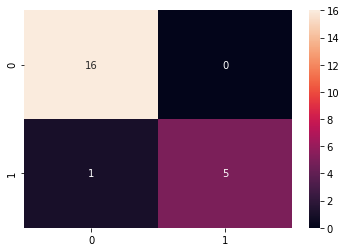

CPU times: user 2.67 s, sys: 1.48 s, total: 4.15 s
Wall time: 1.71 s


,msno,is_churn_prob,is_churn_pred,is_churn
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,0.009696,0,0
1,yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=,0.002362,0,0
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,0.004399,0,0
3,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,0.011992,0,1
4,4De1jAxNRABoyRBDZ82U0yEmzYkqeOugRGVNIf92Xb8=,0.061904,0,0
5,GqYHRxlZChiZvB1uzR410wcQzuxqZNZci4AzOTzkAao=,0.005320,0,0
6,Z6WIOK9vXy+e2XDBiioNAxuZ0ScXSU/Ebq4tUwqVSrE=,0.003930,0,0
7,den0Kb2s4BV47zV+tSC1u0W07M7BOMq+fnrGj+9ax0I=,0.003443,0,0
8,i4kmzPli+nl4XagzznO+oCcPeXfjcLSKIn8xE9oGU5E=,0.003503,0,0
9,XmV2kHCnqnQf4oTJ4LCS7F02cpxnzqGIDDRGHe4dw8c=,0.777831,1,1


In [35]:
%%time
final_fun_2(member,transactions,march,jan,feb,with_is_churn,lode=True)

# model already loaded 

In [40]:
march=pd.read_csv('/home/asad_99rizvi/another_data/march_user_logs_final.csv')
feb=pd.read_csv('/home/asad_99rizvi/another_data/feb_user_logs_final.csv')
jan=pd.read_csv('/home/asad_99rizvi/another_data/jan_user_logs_final.csv')
member=pd.read_csv('/home/asad_99rizvi/another_data/member_data_final.csv',parse_dates=['registration_init_time'])
transactions=pd.read_csv('/home/asad_99rizvi/another_data/transaction_final.csv',parse_dates=['transaction_date','membership_expire_date'])
with_is_churn=pd.read_csv('/home/asad_99rizvi/another_data/with_is_churn.csv')

log loss is  0.5392234466483139
F1 score is 0.9090909090909091


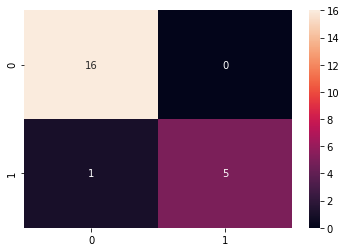

CPU times: user 1.66 s, sys: 1.1 s, total: 2.76 s
Wall time: 968 ms


,msno,is_churn_prob,is_churn_pred,is_churn
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,0.009696,0,0
1,yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=,0.002362,0,0
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,0.004399,0,0
3,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,0.011992,0,1
4,4De1jAxNRABoyRBDZ82U0yEmzYkqeOugRGVNIf92Xb8=,0.061904,0,0
5,GqYHRxlZChiZvB1uzR410wcQzuxqZNZci4AzOTzkAao=,0.005320,0,0
6,Z6WIOK9vXy+e2XDBiioNAxuZ0ScXSU/Ebq4tUwqVSrE=,0.003930,0,0
7,den0Kb2s4BV47zV+tSC1u0W07M7BOMq+fnrGj+9ax0I=,0.003443,0,0
8,i4kmzPli+nl4XagzznO+oCcPeXfjcLSKIn8xE9oGU5E=,0.003503,0,0
9,XmV2kHCnqnQf4oTJ4LCS7F02cpxnzqGIDDRGHe4dw8c=,0.777831,1,1


In [41]:
%%time
final_fun_2(member,transactions,march,jan,feb,with_is_churn,lode=False)

# Although there is no strict latency constraints but our model made 100 prediction in just 583ms